# JURNAL MODUL VI
## I MADE ARYA KRISNANDY
### F1D022048

## import libary

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import math
import pandas as pd
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.exceptions import UndefinedMetricWarning
import warnings

kode diatas merupakan libary yang diperlukan, matplotlib.pyplot digunakan untuk visualisasi data, numpy untuk operasi numerik, dan cv2 dari OpenCV untuk pemrosesan gambar. Pustaka os digunakan untuk operasi sistem file, math untuk operasi matematika, pandas untuk manipulasi data, dan random untuk operasi acak. tqdm digunakan untuk menampilkan progress bar dalam loop, train_test_split dari sklearn.model_selection untuk membagi dataset menjadi data latih dan uji, RandomForestClassifier dari sklearn.ensemble untuk membangun model klasifikasi, dan berbagai metrik evaluasi dari sklearn.metrics seperti confusion_matrix, accuracy_score, precision_score, recall_score, dan f1_score untuk mengukur kinerja model. Peringatan terkait metrik yang tidak terdefinisi diabaikan menggunakan UndefinedMetricWarning dari sklearn.exceptions dan warnings.

## Data Loading

In [2]:
def insertimg(folder, image_size=(150, 150), batch_size=100):
    all_images = []
    all_filenames = []
    all_labels = []

    label_dirs = [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]

    for label in label_dirs:
        label_path = os.path.join(folder, label)
        filenames = os.listdir(label_path)
        
        for i in range(0, len(filenames), batch_size):
            batch_filenames = filenames[i:i + batch_size]
            images = []
            labels = []
            for filename in batch_filenames:
                img_path = os.path.join(label_path, filename)
                img = cv.imread(img_path, cv.IMREAD_COLOR)
                
                if img is not None:
                    resized = cv.resize(img, image_size, interpolation=cv.INTER_AREA) 
                    images.append(resized)
                    labels.append(label)

            all_images.extend(images)
            all_filenames.extend(batch_filenames)
            all_labels.extend(labels)

    return all_images, all_filenames, all_labels

kode diatas adalah Fungsi insertimg yang merupakan fungsi yang bertujuan untuk memuat gambar-gambar dari folder yang ditentukan. Pertama, fungsi ini menginisialisasi tiga list kosong untuk menyimpan semua gambar, nama file, dan label. Selanjutnya, fungsi ini mencari subfolder-subfolder di dalam folder utama yang diinputkan, yang diasumsikan sebagai label-label untuk klasifikasi. Setelah itu, fungsi akan mengelompokkan file-file gambar ke dalam batch sesuai dengan parameter batch_size, kemudian membaca, mengubah ukuran, dan memasukkan gambar-gambar tersebut ke dalam list. Proses ini dilakukan untuk setiap subfolder (label) yang ada. Akhirnya, fungsi ini mengembalikan tiga list yang berisi semua gambar, nama file, dan label yang telah dimuat dari folder-folder dan subfolder-subfolder yang diberikan.

Jumlah total gambar: 2099
Distribusi data per label:
finger_1: 422
finger_2: 419
finger_3: 419
finger_4: 420
finger_5: 419


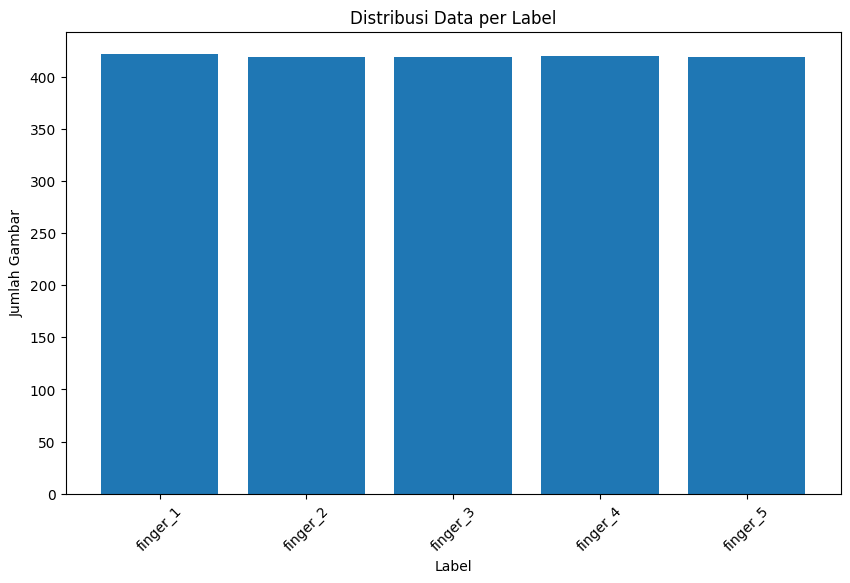

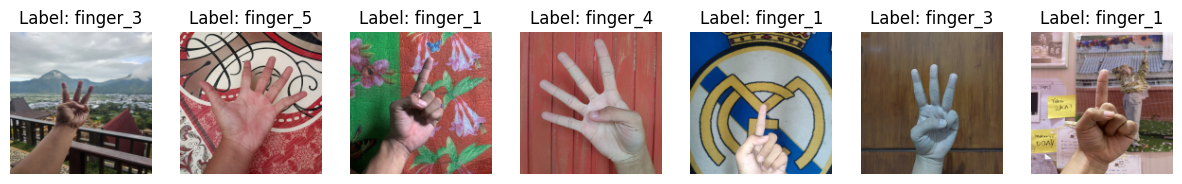

In [4]:
def eskplorasi(images, labels):
    print(f"Jumlah total gambar: {len(images)}")
    
    label_counts = {}
    for label in labels:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1
    print("Distribusi data per label:")
    for label, count in label_counts.items():
        print(f"{label}: {count}")
    
    plt.figure(figsize=(10, 6))
    plt.bar(label_counts.keys(), label_counts.values())
    plt.xlabel("Label")
    plt.ylabel("Jumlah Gambar")
    plt.title("Distribusi Data per Label")
    plt.xticks(rotasi=45)
    plt.show()
    
    num_samples = 7
    sample_indices = np.random.choice(range(len(images)), num_samples, replace=False)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(sample_indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv.cvtColor(images[idx], cv.COLOR_BGR2RGB))
        plt.title(f"Label: {labels[idx]}")
        plt.axis("off")
    plt.show()
    
images, filenames, labels = insertimg("dataset", image_size=(150, 150))
eskplorasi(images,labels)

kode di atas adalah Fungsi eskplorasi yang menerima dua parameter yaitu images yang merupakan daftar gambar dan labels yang merupakan daftar label untuk setiap gambar. Pertama, fungsi ini mencetak jumlah total gambar yang dimuat, kemudian menghitung distribusi data per label dengan menghitung berapa kali setiap label muncul dalam daftar labels. Hasilnya dicetak bersama dengan label yang sesuai. Selanjutnya, fungsi ini membuat sebuah diagram batang yang menunjukkan distribusi data per label, dengan sumbu x menunjukkan label dan sumbu y menunjukkan jumlah gambar untuk setiap label. Setelah itu, fungsi ini memilih secara acak beberapa sampel dari gambar yang dimuat dan menampilkannya dalam bentuk grid, bersama dengan label masing-masing gambar. Setiap gambar ditampilkan bersamaan dengan labelnya. Hasil visualisasi distribusi data dan contoh gambar dari setiap label akan membantu pemahaman lebih lanjut tentang dataset yang digunakan.

## Data Preparation

### Data Augmentation

In [5]:
def rotasi (image, derajat):
        rotated = image.copy()
        sudut= np.deg2rad(derajat)
        heighttengah = int((image.shape[1]-1)/2)
        widthtengah = int((image.shape[0]-1)/2)
        for i in range (rotated.shape[0]):
            for j in range (rotated.shape[1]):
                x=(i-heighttengah)*np.cos(sudut)+(j-widthtengah)*np.sin(sudut)
                y=-(i-heighttengah)*np.sin(sudut)+(j-widthtengah)*np.cos(sudut)
                x = int(x + heighttengah)
                y = int(y + widthtengah)
                if x>=0 and y>=0 and x<rotated.shape[0] and y<rotated.shape[1] :
                    rotated[i][j]= image[x][y]
        return rotated

kode di atas adalah Fungsi rotasi yang menerima dua parameter yaitu image, yang merupakan gambar yang akan diputar, dan derajat, yang merupakan sudut rotasi yang diinginkan. Fungsi ini melakukan rotasi gambar sebesar sudut yang diberikan menggunakan transformasi geometri. Pertama, gambar asli disalin untuk menghindari modifikasi langsung pada gambar asli. Kemudian, sudut rotasi diubah menjadi radian menggunakan fungsi np.deg2rad. Variabel heighttengah dan widthtengah menghitung titik tengah gambar berdasarkan dimensi gambar. Fungsi kemudian melakukan iterasi pada setiap piksel gambar yang diputar. Untuk setiap piksel, koordinat x dan y piksel setelah rotasi dihitung menggunakan rumus transformasi rotasi. Kemudian, nilai piksel pada posisi baru tersebut diambil dari gambar asli dan ditetapkan ke posisi piksel pada gambar yang diputar, dengan memastikan bahwa nilai x dan y yang dihitung berada dalam batas gambar yang diputar. Akhirnya, gambar yang telah diputar dikembalikan.

In [6]:
def mirroring(image, axis):
        mirrored = image.copy()
        if axis == 0:
            for i in range (mirrored.shape[0]):
                for j in range (mirrored.shape[1]):
                    mirrored[i][j] = image[mirrored.shape[0]-1-i][j]
        elif axis == 1:
            for i in range (mirrored.shape[0]):
                for j in range (mirrored.shape[1]):
                    mirrored[i][j] = image[i][mirrored.shape[1]-1-j]
        return mirrored

Fungsi mirroring menerima dua parameter: image, yang merupakan gambar yang akan dicerminkan, dan axis, yang menunjukkan sumbu cermin (0 untuk vertikal dan 1 untuk horizontal). Fungsi ini membuat salinan dari gambar asli untuk memulai proses pencerminan. Jika axis adalah 0, fungsi melakukan iterasi pada setiap piksel gambar dan mencerminkannya secara vertikal dengan menukar baris atas dengan baris bawah. Jika axis adalah 1, fungsi mencerminkan gambar secara horizontal dengan menukar kolom kiri dengan kolom kanan. Pada akhirnya, gambar yang sudah dicerminkan dikembalikan. Fungsi ini menggunakan perulangan for untuk mengakses setiap piksel dan mengatur piksel baru berdasarkan posisi piksel cerminnya.

In [8]:
def augmentasi(data, filenames, banyakData=4):
    augmented_data = []
    augmented_filenames = []
    for i in tqdm(range(len(data))):
        augmented_data.append(data[i])
        augmented_filenames.append(filenames[i])
        used_angles = set()
        for j in range(banyakData):
            image = data[i]
            possible_angles = [angle for angle in range(5, 360, 5) if angle not in used_angles]
            sudut = random.choice(possible_angles)
            while sudut in used_angles:
                sudut = random.randint(1, 360)
            used_angles.add(sudut)
            augment = random.randint(0, 1)
            if augment == 0:
                image = rotasi(image, sudut)
                image = mirroring(image, 0)
            else:
                image = rotasi(image, sudut)
                image = mirroring(image, 1)
            augmented_data.append(image)
            augmented_filenames.append(filenames[i])
    return augmented_data, augmented_filenames

kode di atas adalah Fungsi augmentasi yang bertujuan memperluas dataset gambar dengan menghasilkan variasi tambahan untuk setiap gambar asli, menggunakan rotasi dan pencerminan. Fungsi ini menerima tiga parameter: data (daftar gambar), filenames (daftar nama file), dan banyakData (jumlah variasi tambahan yang diinginkan per gambar, default 4). Untuk setiap gambar dalam dataset, fungsi menambahkan gambar asli ke list hasil augmentasi, kemudian menghasilkan variasi tambahan dengan memilih sudut rotasi acak yang belum digunakan dan mencerminkan gambar secara vertikal atau horizontal. Hasil augmentasi dan nama file yang sesuai ditambahkan ke list yang akan dikembalikan. Proses ini memastikan dataset yang lebih besar dan lebih beragam, yang berguna untuk melatih model pembelajaran mesin.

In [9]:
augmentasiData, augmentasiFilenames = augmentasi(images, filenames)

100%|██████████| 2099/2099 [14:54<00:00,  2.35it/s]


kode di atas memanggil fungsi augmentasi untuk memperluas dataset gambar dengan menghasilkan variasi tambahan melalui rotasi dan pencerminan.

In [10]:
def grayscale(img):
    gaussKernel = np.ones((3,3))/9
    r = img[:,:,2]
    g = img[:,:,1]
    b = img[:,:,0]
    filteredR = cv.filter2D(r,-1,gaussKernel)
    filteredG = cv.filter2D(g,-1,gaussKernel)
    filteredB = cv.filter2D(b,-1,gaussKernel)
    return np.round(filteredR/3 + filteredG/3 + filteredB/3).astype(np.uint8)

kode di atas adalah Fungsi grayscale yang mengonversi gambar berwarna menjadi skala abu-abu dengan menggunakan kernel Gaussian 3x3 untuk menghaluskan gambar. Fungsi ini mengekstrak kanal merah, hijau, dan biru dari gambar, lalu menerapkan filter Gaussian pada masing-masing kanal. Setelah difilter, setiap kanal dibagi rata dan hasilnya dijumlahkan, dibulatkan, dan dikonversi ke tipe data np.uint8 untuk menghasilkan gambar akhir dalam skala abu-abu.

In [11]:
def grayscaleData(data):
    gray_data = []
    for i in tqdm(range(len(data))):
        gray_data.append(grayscale(data[i]))
    return gray_data

kode di atas adalah Fungsi grayscaleData menerima parameter data, yaitu daftar gambar berwarna, dan mengembalikan daftar baru gray_data yang berisi gambar-gambar tersebut dalam skala abu-abu. Untuk setiap gambar dalam data, fungsi ini memanggil grayscale, yang mengonversi gambar berwarna menjadi skala abu-abu dengan menerapkan filter Gaussian pada kanal merah, hijau, dan biru, lalu menggabungkannya. Proses ini dilakukan dalam sebuah loop yang ditampilkan dengan progress bar menggunakan tqdm untuk memantau kemajuan, dan hasil akhirnya adalah daftar gray_data yang berisi semua gambar yang telah dikonversi.

In [12]:
grayAugmentedData = grayscaleData(augmentasiData)

100%|██████████| 10495/10495 [00:02<00:00, 4860.56it/s]


In [19]:
def findPixel(img,skala=256):
    pixel = np.zeros(skala)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            pixel[int(img[i,j])] =  pixel[int(img[i,j])] + 1
    return pixel

kode di atas merupakan Fungsi findPixel yang menghitung frekuensi setiap nilai piksel dalam gambar img dan mengembalikannya sebagai array pixel dengan panjang sesuai dengan skala (default 256).

In [22]:
def findProbability(img, pixel,skala=256):
    for i in range(skala):
        pixel[i] = pixel [i] / (img.shape[0] * img.shape[1])
    return pixel

kode di atas merupakan Fungsi findProbability yang menghitung probabilitas kemunculan setiap nilai piksel dengan membagi frekuensi piksel dengan total jumlah piksel dalam gambar, mengubah array pixel menjadi array probabilitas.

In [21]:
def findCumulative(arr,skala=256):
    for i in range(skala):
        if i != 0:
            arr[i] = arr[i] + arr[i-1]
    return arr

kode di atas merupakan Fungsi findCumulative yang menghitung distribusi kumulatif dari array probabilitas, yang digunakan untuk ekualisasi histogram.

In [20]:
def ekualisasi(img):
    pixel = findPixel(img)
    pixel = findProbability(img,pixel)
    pixel = findCumulative(pixel)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img[i,j] = pixel[int(img[i,j])] * 255
    return img

kode di atas merupakan Fungsi ekualisasi memanfaatkan ketiga fungsi ini untuk mengonversi nilai piksel gambar berdasarkan distribusi kumulatif yang telah dihitung, meningkatkan kontras gambar.

In [14]:
def ekualisasiData(data):
    equalized_data = []
    for i in tqdm(range(len(data))):
        equalized_data.append(ekualisasi(data[i]))
    return equalized_data

kode di atas merupakan Fungsi ekualisasiData menerapkan ekualisasi histogram pada setiap gambar dalam daftar data, menghasilkan daftar equalized_data yang berisi gambar-gambar dengan kontras yang telah ditingkatkan. Proses ini dilakukan dengan menggunakan progress bar tqdm untuk memantau kemajuan.

In [15]:
equalData = ekualisasiData(grayAugmentedData)

100%|██████████| 10495/10495 [03:01<00:00, 57.70it/s]


### Preprocessing

In [23]:
def addpadding(image, kernel):
    i = (kernel.shape[1]-1)//2
    j = (kernel.shape[0]-1)//2
    left = i
    right = (kernel.shape[1]-1)-i
    top = j
    bottom = (kernel.shape[0]-1)-j
    results = np.pad(image, ((top, bottom),(left, right)), mode="edge")
    return results

kode di atas merupakan Fungsi addpadding yang menambahkan tepi pada gambar menggunakan metode yang ditentukan (dalam hal ini, mode "edge").

In [24]:
def sortArray(filter):
    for i in range(len(filter)-1):
        for j in range(i+1,len(filter)):
            if filter[i] > filter[j]:
                temp = filter[i]
                filter[i] = filter[j]
                filter[j] = temp
    return filter

kode di atas merupakan Fungsi sortArray yang akan mengurutkan array yang diberikan dalam urutan non-menurun.

In [25]:
def findMedian(filter):
    sorted_array = sortArray(filter)
    length = len(filter)
    if length % 2 == 0:
        x1 = (length // 2) - 1
        x2 = x1 + 1
        value = (sorted_array[x1] + sorted_array[x2]) // 2
        return int(value)
    else:
        value = (length // 2)
        return int(sorted_array[value])

kode di atas merupakan Fungsi findMedian yang akan menemukan nilai median dari array yang diurutkan.

In [26]:
def medianFiltering(image, kernel):
    result = np.zeros([image.shape[0], image.shape[1]], dtype=np.uint8)
    paddingImage = addpadding(image, kernel)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            temp = []
            for k in range(kernel.shape[0]):
                for l in range(kernel.shape[1]):
                    temp.append(paddingImage[i+k, j+l])
            value = findMedian(temp)
            result[i][j] = value
    return result

kode di atas merupakan Fungsi medianFiltering yang menerapkan filter median pada gambar menggunakan kernel yang ditentukan, dengan cara mengiterasi melalui setiap piksel pada gambar, mengambil nilai piksel di sekitar setiap piksel dengan ukuran kernel, kemudian menemukan nilai median dari nilai-nilai tersebut untuk menghasilkan gambar yang difilter.

In [16]:
def medianFilteringData(data):
    kernel = np.ones((3,3))
    median_filtered_data = []
    for i in tqdm(range(len(data))):
        median_filtered_data.append(medianFiltering(data[i], kernel))
    return median_filtered_data

kode di atas merupakan Fungsi medianFilteringData yang menerapkan filter median pada setiap gambar dalam dataset menggunakan kernel 3x3, dan mengembalikan daftar median_filtered_data yang berisi gambar-gambar yang telah difilter. Proses ini dilakukan dengan menggunakan progress bar tqdm untuk memantau kemajuan.

In [17]:
medianEqualData = medianFilteringData(equalData)

100%|██████████| 10495/10495 [15:03<00:00, 11.61it/s]


In [18]:
def normalisasi (image):
    min_val = np.min(image)
    max_val = np.max(image)
    
    normalisasi_img = (image-min_val)/(max_val-min_val)
    uint8_img = (normalisasi_img * 255).astype(np.uint8)
    
    return uint8_img

kode di atas merupakan Fungsi normalisasi yang menerima sebuah gambar dan menghitung nilai minimum dan maksimum dari intensitas piksel dalam gambar tersebut. Kemudian, fungsi ini mengaplikasikan normalisasi linier pada gambar dengan mengubah rentang nilai piksel menjadi [0, 255] dan mengembalikan gambar hasil normalisasi dengan tipe data np.uint8.

In [27]:
def normalisasiData(data):
    normalized_data = []
    for i in tqdm(range(len(data))):
        normalized_data.append(normalisasi(data[i]))
    return normalized_data

kode diatas merupakan Fungsi normalisasiData yang menerima dataset gambar dan mengaplikasikan normalisasi pada setiap gambar dalam dataset tersebut. Proses normalisasi dilakukan dengan iterasi melalui setiap gambar dalam dataset, dan hasil normalisasi dimasukkan ke dalam daftar normalized_data. Proses ini dilakukan dengan menggunakan progress bar tqdm untuk memantau kemajuan. Hasil akhirnya adalah daftar gambar yang telah dinormalisasi intensitas pikselnya.

In [28]:
normalData = normalisasiData(medianEqualData)

100%|██████████| 10495/10495 [00:00<00:00, 13826.49it/s]


### Feature Extraction

In [29]:
def hitung_glcm(image, distances=[1], angles=[0, 45, 90, 135], levels=256):
    glcm_matrices = []
    
    max_val = np.max(image)
    min_val = np.min(image)
    image_normalized = ((image - min_val) / (max_val - min_val) * (levels - 1)).astype(np.uint8)
    
    for angle in angles:
        glcm_matrix = np.zeros((levels, levels))
        for distance in distances:
            offset_x = int(round(distance * np.cos(np.radians(angle))))
            offset_y = int(round(distance * np.sin(np.radians(angle))))
            for i in range(image.shape[0]):
                for j in range(image.shape[1]):
                    if 0 <= i + offset_y < image.shape[0] and 0 <= j + offset_x < image.shape[1]:
                        pixel_value = image_normalized[i, j]
                        neighbor_value = image_normalized[i + offset_y, j + offset_x]
                        glcm_matrix[pixel_value, neighbor_value] += 1
        glcm_matrices.append(glcm_matrix)
    return glcm_matrices

def hitung_glcm_features(glcm_matrices):
    features = []
    for glcm_matrix in glcm_matrices:
        glcm_matrix /= np.sum(glcm_matrix)
        
        contrast = np.sum(glcm_matrix * np.square(np.arange(glcm_matrix.shape[0]) - np.arange(glcm_matrix.shape[1])))
        dissimilarity = np.sum(glcm_matrix * np.abs(np.arange(glcm_matrix.shape[0]) - np.arange(glcm_matrix.shape[1])))

        homogeneity = np.sum(glcm_matrix / (1 + np.square(np.arange(glcm_matrix.shape[0]) - np.arange(glcm_matrix.shape[1]))))
        energy = np.sum(np.square(glcm_matrix))
        correlation = np.sum((np.arange(glcm_matrix.shape[0]) - np.mean(glcm_matrix)) * 
                             (np.arange(glcm_matrix.shape[1]) - np.mean(glcm_matrix)) * glcm_matrix / 
                             (np.std(glcm_matrix) ** 2))
        entropy = -np.sum(glcm_matrix * np.log(glcm_matrix + 1e-10))
        asm = np.sum(np.square(glcm_matrix))
        
        features.append({
            "contrast": contrast,
            "dissimilarity": dissimilarity,
            "homogeneity": homogeneity,
            "energy": energy,
            "correlation": correlation,
            "entropy": entropy,
            "ASM": asm
        })
    return features


edge_images_prewitt_rotated = [
    np.random.randint(0, 256, size=(100, 100)),
    np.random.randint(0, 256, size=(100, 100)),
]

glcm_matrices = []
for edge_image in edge_images_prewitt_rotated:
    glcm_matrices.extend(hitung_glcm(edge_image))

glcm_features = hitung_glcm_features(glcm_matrices)

data = []
columns = ["Image", "Contrast", "Dissimilarity", "Homogeneity", "Energy", "Correlation", "Entropy", "ASM"]
for angle in [0, 45, 90, 135]:
    columns.extend([f"contrast_{angle}", f"dissimilarity_{angle}", f"homogeneity_{angle}", 
                    f"energy_{angle}", f"correlation_{angle}", f"asm_{angle}", f"entropy_{angle}"])

for i, features in enumerate(glcm_features):
    row = [i + 1, features["contrast"], features["dissimilarity"], features["homogeneity"], 
           features["energy"], features["correlation"], features["entropy"], features["ASM"]]
    for angle in [0, 45, 90, 135]:
        row.extend([features["contrast"], features["dissimilarity"], features["homogeneity"], 
                    features["energy"], features["correlation"], features["entropy"], features["ASM"]])
    data.append(row)

df = pd.DataFrame(data, columns=columns)

print(df)
df.head()

   Image  Contrast  Dissimilarity  Homogeneity    Energy   Correlation  \
0      1       0.0            0.0          1.0  0.000116  1.429903e+13   
1      2       0.0            0.0          1.0  0.000117  1.418720e+13   
2      3       0.0            0.0          1.0  0.000117  1.414454e+13   
3      4       0.0            0.0          1.0  0.000117  1.415843e+13   
4      5       0.0            0.0          1.0  0.000117  1.422121e+13   
5      6       0.0            0.0          1.0  0.000118  1.411443e+13   
6      7       0.0            0.0          1.0  0.000117  1.421298e+13   
7      8       0.0            0.0          1.0  0.000117  1.422098e+13   

    Entropy       ASM  contrast_0  dissimilarity_0  ...  correlation_90  \
0  9.101924  0.000116         0.0              0.0  ...    1.429903e+13   
1  9.093536  0.000117         0.0              0.0  ...    1.418720e+13   
2  9.096112  0.000117         0.0              0.0  ...    1.414454e+13   
3  9.094926  0.000117         0.0

,Image,Contrast,Dissimilarity,Homogeneity,Energy,Correlation,Entropy,ASM,contrast_0,dissimilarity_0,...,correlation_90,asm_90,entropy_90,contrast_135,dissimilarity_135,homogeneity_135,energy_135,correlation_135,asm_135,entropy_135
0,1,0.0,0.0,1.0,0.000116,1.429903e+13,9.101924,0.000116,0.0,0.0,...,1.429903e+13,9.101924,0.000116,0.0,0.0,1.0,0.000116,1.429903e+13,9.101924,0.000116
1,2,0.0,0.0,1.0,0.000117,1.418720e+13,9.093536,0.000117,0.0,0.0,...,1.418720e+13,9.093536,0.000117,0.0,0.0,1.0,0.000117,1.418720e+13,9.093536,0.000117
2,3,0.0,0.0,1.0,0.000117,1.414454e+13,9.096112,0.000117,0.0,0.0,...,1.414454e+13,9.096112,0.000117,0.0,0.0,1.0,0.000117,1.414454e+13,9.096112,0.000117
3,4,0.0,0.0,1.0,0.000117,1.415843e+13,9.094926,0.000117,0.0,0.0,...,1.415843e+13,9.094926,0.000117,0.0,0.0,1.0,0.000117,1.415843e+13,9.094926,0.000117
4,5,0.0,0.0,1.0,0.000117,1.422121e+13,9.094450,0.000117,0.0,0.0,...,1.422121e+13,9.094450,0.000117,0.0,0.0,1.0,0.000117,1.422121e+13,9.094450,0.000117


Kode di atas berfungsi untuk menghitung fitur GLCM (Gray-Level Co-occurrence Matrix) dari serangkaian gambar. Pertama, fungsi hitung_glcm digunakan untuk menghitung matriks GLCM dari gambar, dengan menghitung matriks GLCM untuk setiap sudut yang ditentukan dan jarak yang ditentukan. Kemudian, fungsi hitung_glcm_features digunakan untuk menghitung fitur GLCM seperti kontras, dissimilaritas, homogenitas, energi, korelasi, entropi, dan asm dari matriks GLCM yang dihasilkan. Selanjutnya, kode tersebut mendemonstrasikan penggunaan fungsi-fungsi tersebut dengan menghitung fitur GLCM dari serangkaian gambar yang dihasilkan secara acak, dan menyusun hasilnya ke dalam sebuah DataFrame. DataFrame tersebut berisi fitur GLCM untuk setiap sudut yang dihitung, termasuk masing-masing fitur untuk setiap sudut.

### Features Selection

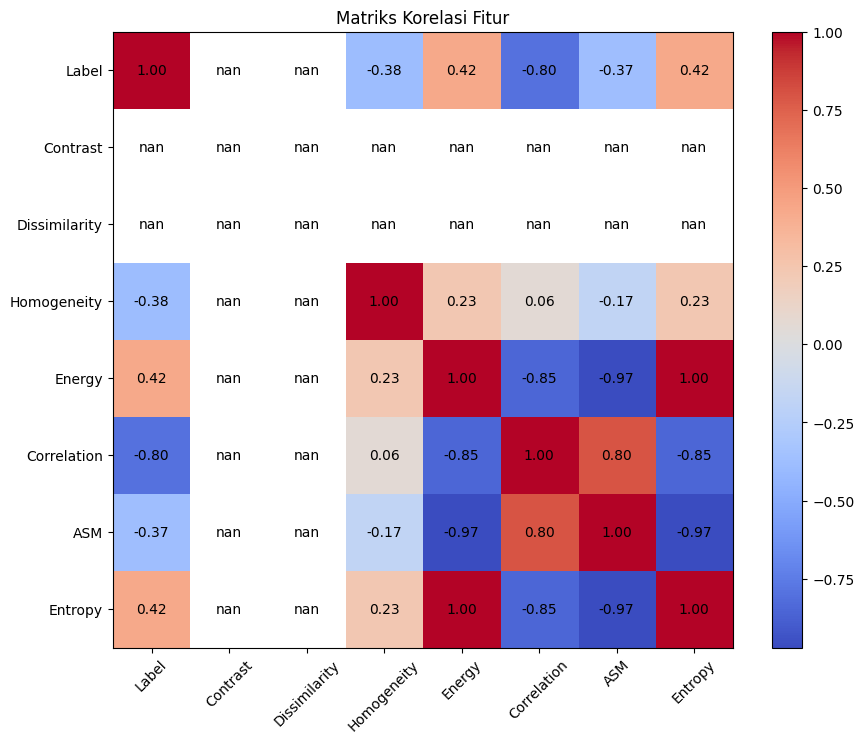

Selected Features: []
Selected Features: []
     Filename  Label  Contrast  Dissimilarity  Homogeneity    Energy  \
0  Filename_0      0       0.0            0.0          1.0  0.000117   
1  Filename_1      1       0.0            0.0          1.0  0.000116   
2  Filename_2      2       0.0            0.0          1.0  0.000116   
3  Filename_3      3       0.0            0.0          1.0  0.000117   
4  Filename_4      4       0.0            0.0          1.0  0.000117   

    Correlation       ASM   Entropy  
0  1.413811e+13  9.093385  0.000117  
1  1.423274e+13  9.095834  0.000116  
2  1.423814e+13  9.098809  0.000116  
3  1.405726e+13  9.088705  0.000117  
4  1.407483e+13  9.096603  0.000117  


In [30]:
def feature_selection_correlation(results):
    data = []
    columns = ["Filename", "Label", "Contrast", "Dissimilarity", "Homogeneity", "Energy", "Correlation", "ASM", "Entropy"]
    for fname, label, features in results:
        row = [fname, label]
        row.extend(features.values())
        data.append(row)
    
    df = pd.DataFrame(data, columns=columns)
    
    df["Label"] = df["Label"].astype("category").cat.codes
    
    numeric_df = df.drop(columns=["Filename"])
    
    corr = numeric_df.corr()
    
    plt.figure(figsize=(10, 8))
    plt.title("Matriks Korelasi Fitur")
    plt.imshow(corr, cmap="coolwarm", interpolation="none", aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotasi=45)
    plt.yticks(range(len(corr.index)), corr.index)
    for i in range(len(corr.columns)):
        for j in range(len(corr.index)):
            plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", color="black")
    plt.show()
    
    selected_features = corr["Label"][(corr["Label"] > 0.99) | (corr["Label"] < -0.99)].index.tolist()
    selected_features.remove("Label")
    
    print("Selected Features:", selected_features)
    
    return df, selected_features

edge_images_prewitt_rotated = [
    np.random.randint(0, 256, size=(100, 100)),
    np.random.randint(0, 256, size=(100, 100)),
]

glcm_matrices = []
for edge_image in edge_images_prewitt_rotated:
    glcm_matrices.extend(hitung_glcm(edge_image))

glcm_features = hitung_glcm_features(glcm_matrices)

results = []
for i, features in enumerate(glcm_features):
    results.append((f"Filename_{i}", f"Label_{i}", features))

df_selected, selected_features = feature_selection_correlation(results)
print("Selected Features:", selected_features)
print(df_selected.head())

kode di atas adalah Fungsi feature_selection_correlation yang bertujuan untuk melakukan seleksi fitur berdasarkan korelasi antara fitur-fitur tersebut dan label kelas. Pertama, fungsi ini menyusun data fitur dari hasil ekstraksi GLCM ke dalam DataFrame, kemudian menghitung matriks korelasi antara fitur-fitur numerik dan label kelas. Selanjutnya, fungsi ini memvisualisasikan matriks korelasi menggunakan heatmap, dan memilih fitur-fitur yang memiliki korelasi kuat (lebih besar dari 0.99 atau lebih kecil dari -0.99) dengan label kelas. Fitur-fitur yang dipilih kemudian dihapus dari DataFrame, dan nama fitur-fitur yang terpilih dicetak. Hasil akhirnya adalah DataFrame yang telah diproses dan daftar fitur-fitur terpilih berdasarkan korelasi. Kode tersebut juga mendemonstrasikan penggunaan fungsi tersebut dengan menghasilkan data fitur dari beberapa gambar yang dihasilkan secara acak dan menyusun hasilnya.

### Splitting Data

In [31]:
X = df_selected.drop(columns=["Label"])
y = df_selected["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (6, 8)
Testing data shape: (2, 8)


kode di atas, variabel X menampung DataFrame yang telah diproses (df_selected) dengan kolom label ("Label") dihapus, sehingga hanya menyisakan fitur-fitur yang akan digunakan sebagai data input. Variabel y menampung kolom label ("Label") dari DataFrame yang diproses, yang akan digunakan sebagai target prediksi. Selanjutnya, dilakukan pembagian data menjadi data latih dan data uji menggunakan fungsi train_test_split dengan rasio data uji sebesar 0.2 (20%) dari seluruh data, dan ditentukan pula seed untuk random state. Informasi tentang bentuk data latih dan data uji kemudian dicetak untuk memeriksa hasilnya.

### Normalization

In [32]:
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

def min_max_normalization(data):
    min_val = data.min()
    max_val = data.max()
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

X_train_normalized = X_train_numeric.apply(min_max_normalization, axis=0)

X_test_normalized = X_test_numeric.apply(min_max_normalization, axis=0)

print("Normalized Training data shape :", X_train_normalized.shape)
print("Normalized Testing data shape:", X_test_normalized.shape)

Normalized Training data shape : (6, 7)
Normalized Testing data shape: (2, 7)


kode di atas, variabel X_train_numeric dan X_test_numeric disusun untuk menampung fitur-fitur numerik dari data latih dan data uji, masing-masing. Fungsi select_dtypes digunakan untuk memilih kolom-kolom dengan tipe data numerik saja dari DataFrame. Selanjutnya, didefinisikan fungsi min_max_normalization untuk melakukan normalisasi min-max terhadap data numerik. Fungsi ini menghitung nilai minimum dan maksimum dari setiap fitur, kemudian melakukan normalisasi terhadap nilai-nilai tersebut. Proses normalisasi dilakukan menggunakan metode min-max, yaitu dengan mengurangkan nilai minimum dari setiap nilai dan kemudian membaginya dengan selisih nilai maksimum dan nilai minimum. Data latih dan data uji kemudian dinormalisasi menggunakan fungsi apply dengan menyertakan fungsi normalisasi yang telah didefinisikan sebelumnya. Informasi tentang bentuk data latih dan data uji yang telah dinormalisasi kemudian dicetak untuk memeriksa hasilnya.

## Modeling

In [33]:
X_train_numeric = X_train.drop(columns=["Filename"])
X_test_numeric = X_test.drop(columns=["Filename"])

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train_numeric, y_train)

y_pred_train = rf_classifier.predict(X_train_numeric)
y_pred_test = rf_classifier.predict(X_test_numeric)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Training Accuracy:", accuracy_train)
print("Testing Accuracy:", accuracy_test)

Training Accuracy: 1.0
Testing Accuracy: 0.0


kode di atas, variabel X_train_numeric dan X_test_numeric disusun untuk menampung data latih dan data uji tanpa kolom "Filename", sehingga hanya menyisakan fitur-fitur yang akan digunakan sebagai data input. Kemudian, dilakukan pembuatan model klasifikasi menggunakan algoritma Random Forest Classifier dengan 100 pohon keputusan dan seed untuk random state ditetapkan sebagai 42. Model klasifikasi ini kemudian dilatih dengan menggunakan data latih (X_train_numeric) dan label kelasnya (y_train) menggunakan metode fit. Setelah model terlatih, dilakukan prediksi terhadap data latih dan data uji menggunakan metode predict. Kemudian, akurasi dari model terhadap data latih dan data uji dihitung menggunakan fungsi accuracy_score dan dicetak. 

## Evaluation

In [34]:
X_train_numeric = X_train.drop(columns=["Filename"])
X_test_numeric = X_test.drop(columns=["Filename"])

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train_numeric, y_train)

y_pred_train = rf_classifier.predict(X_train_numeric)
y_pred_test = rf_classifier.predict(X_test_numeric)

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

conf_matrix_train = confusion_matrix(y_train, y_pred_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

precision_train = precision_score(y_train, y_pred_train, average="macro", zero_division="warn")
precision_test = precision_score(y_test, y_pred_test, average="macro", zero_division="warn")

recall_train = recall_score(y_train, y_pred_train, average="macro", zero_division="warn")
recall_test = recall_score(y_test, y_pred_test, average="macro", zero_division="warn")

f1_train = f1_score(y_train, y_pred_train, average="macro", zero_division="warn")
f1_test = f1_score(y_test, y_pred_test, average="macro", zero_division="warn")

print("Evaluation Metrics:")
print("-----------------------------------------------------")
print("| Metric      |   Training Set   |   Testing Set    |")
print("-----------------------------------------------------")
print("| Accuracy    |    {:.4f}        |    {:.4f}        |".format(accuracy_train, accuracy_test))
print("| Precision   |    {:.4f}        |    {:.4f}        |".format(precision_train, precision_test))
print("| Recall      |    {:.4f}        |    {:.4f}        |".format(recall_train, recall_test))
print("| F1-score    |    {:.4f}        |    {:.4f}        |".format(f1_train, f1_test))
print("-----------------------------------------------------")

print("Confusion Matrix:")
print("Training Set")
print(conf_matrix_train)
print("\nTesting Set")
print(conf_matrix_test)

Evaluation Metrics:
-----------------------------------------------------
| Metric      |   Training Set   |   Testing Set    |
-----------------------------------------------------
| Accuracy    |    1.0000        |    0.0000        |
| Precision   |    1.0000        |    0.0000        |
| Recall      |    1.0000        |    0.0000        |
| F1-score    |    1.0000        |    0.0000        |
-----------------------------------------------------
Confusion Matrix:
Training Set
[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]

Testing Set
[[0 1 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 1 0]]


kode di atas melakukan evaluasi model klasifikasi Random Forest Classifier dengan metrik evaluasi yang lebih lengkap, serta mencetak matriks kebingungan (confusion matrix) dari data latih dan data uji. Setelah prediksi dilakukan terhadap data latih dan data uji, metrik evaluasi seperti akurasi, presisi, recall, dan F1-score dihitung menggunakan fungsi-fungsi dari scikit-learn. Fungsi warnings.filterwarnings digunakan untuk menyembunyikan peringatan jika terjadi pembagian nol pada perhitungan metrik. Selanjutnya, matriks kebingungan untuk data latih dan data uji dicetak ke layar. 